In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [2]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-0aaxvps0
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0e2abff4864c2895987c866a18db399991e0d7f50_-py3-none-any.whl size=150455 sha256=756728644a407496237d137a6b400acd0807c5c69b50ef5ee739191824923775
  Stored in directory: /tmp/pip-ephem-wheel-cache-ckfy4qnp/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [4]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"  #임시 파일을 만들어주는 코드
#텐서보드에 모델을 학습해서 나온 결과물을 저장해서 시각화하기 위함임.

shutil.rmtree(logdir, ignore_errors=True)   #하위 디렉토리를 전부 없애주는 코드라고 함.

In [5]:
#데이터 로드
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816409600/2816407858 [==============================] - 77s 0us/step


In [6]:
#피쳐는 28개
FEATURES = 28

In [7]:
#압축된 파일을 따로 풀지 않아도 사용할 수 있음.
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

In [8]:
def pack_row(*row) :
    label = row[0]   #원래 데이터 상에서 라벨이 가장 앞에 있기 때문에 [0]으로 한 듯.
    features = tf.stack(row[1:], 1)
    
    return features, label

In [9]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()   #만개의 데이터를 묶어서 가져옴.

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


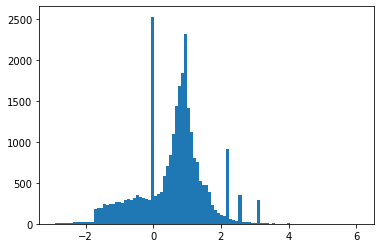

In [11]:
#배치로 묶은 걸 풀 것
#1000개로 다시 묶음(???? 왜...?)

for features, label in packed_ds.batch(1000).take(1) :
    print(features[0])
    plt.hist(features.numpy().flatten(), bins = 101)

In [12]:
N_VALIDATION = int(1e3)   #천 개의 데이터
N_TRAIN = int(1e4)  #만 개의 데이터
BUFFER_SIZE = int(1e4)  #만
BATCH_SIZE = 500 
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE  #에폭 스텝을 지정

In [13]:
validate_ds = packed_ds.take(N_VALIDATION).cache() 
#매번 가져와야하는데 매번 가져오기 번거로우니까 임시로 저장하는 것 .cache()

In [14]:
#천번까지는 val이 들어가 있으니 skip을 하고 1001번부터 만개를 train데이터로 넣는 것
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [15]:
validate_ds = validate_ds.batch(BATCH_SIZE) #배차 사이즈에 맞게 나눔
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE) 
#val,train을 데이터를 섞어줌(shuffle), 버퍼 사이즈만큼!
#보통 데이터 수 만큼 섞음.

In [16]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False) #최적점 가까울 땐 세밀하게 조정하기 위해 스텝을 줌.
                #처음에는 0.001로 시작, rate에 맞게 학습률을 줄여 줌.
def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule) #옵티마이저는 아담으로 지정

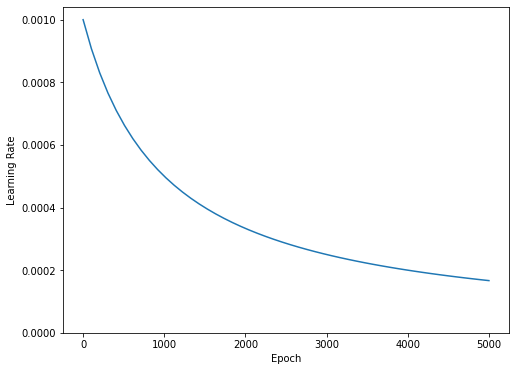

In [17]:
#step을 적용한 위의 코드가 잘 작동하는 것을 시각화하는 코드

step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [18]:
#콜백 함수
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(), #에폭마다 점을 찍게 함.
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]    #200번 동안 유의미한 변화가 없으면 학습을 멈추게 함.
       #텐서보드를 만들기 위해 데이터를 저장함.

In [19]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer() #위에서 적용한 아담을 옵티마이저에 넣은 것.
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)

  return history

## Tiny model

In [21]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [22]:
size_histories = {}  #각 모델마다 나오는 결과들을 이 딕셔너리에 저장할 것.

In [23]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4720,  binary_crossentropy:0.7924,  loss:0.7924,  val_accuracy:0.4690,  val_binary_crossentropy:0.7524,  val_loss:0.7524,  
....................................................................................................
Epoch: 100, accuracy:0.6019,  binary_crossentropy:0.6231,  loss:0.6231,  val_accuracy:0.5850,  val_binary_crossentropy:0.6232,  val_loss:0.6232,  
....................................................................................................
Epoch: 200, accuracy:0.63

(0.5, 0.7)

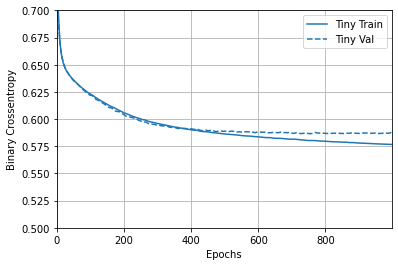

In [24]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

## Small model

In [25]:
small_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [26]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4972,  binary_crossentropy:0.7169,  loss:0.7169,  val_accuracy:0.4790,  val_binary_crossentropy:0.7087,  val_loss:0.7087,  
....................................................................................................
Epoch: 100, accuracy:0.6366,  binary_crossentropy:0.6034,  loss:0.6034,  val_accuracy:0.6070,  val_binary_crossentropy:0.6059,  val_loss:0.

(0.5, 0.7)

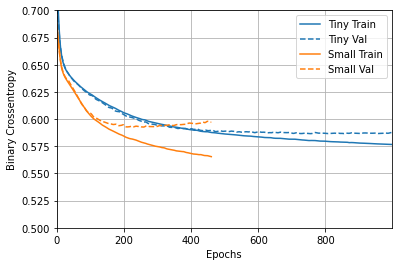

In [27]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

## Medium model

In [28]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [29]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4968,  binary_crossentropy:0.6917,  loss:0.6917,  val_accuracy:0.5180,  val_binary_crossentropy:0.6761,  val_loss:0.6761,  
....................................................................................................
E

(0.5, 0.7)

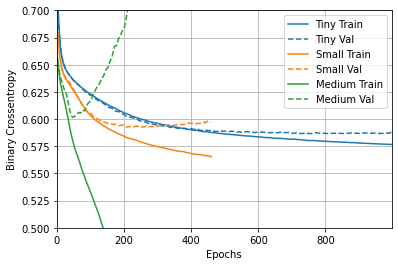

In [30]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

## Large model

In [31]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [32]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5120,  binary_crossentropy:0.7729,  loss:0.7729,  val_accuracy:0.5510,  val_binary_crossentr

(0.5, 0.7)

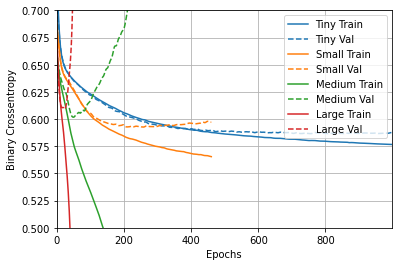

In [33]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

Text(0.5, 0, 'Epochs [Log Scale]')

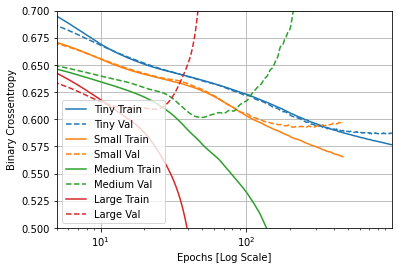

In [34]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [35]:
%load_ext tensorboard

%tensorboard --logdir {logdir}/sizes

In [36]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

# Strategies to prevent overfitting

In [37]:
#전체 디렉토리 트리 삭제, 에러가 나와도 무시하고 실행.
#전체 디렉토리를 새로운 이름으로 복사, 저장 하는 것
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmp/tmplc_hx7tw/tensorboard_logs/regularizers/Tiny')

In [38]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

In [39]:
#tf.keras에서는 가중치 규제 객체를 층의 키워드 매개변수에 전달하여 가중치에 규제를 추가함.
#L2 가중치 규제를 추가해 볼 것.

l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])   #l2(0.001)는 네트워크의 전체 손실에 층에 있는 가중치 행렬의 모든 값이 0.001 * weight_coefficient_value**2만큼 더해진다는 의미.
     #이런 페널티(penalty)는 훈련할 때만 추가됨.
     #테스트 단계보다 훈련 단계에서 네트워크 손실이 훨씬 더 클 것
    
regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5015,  binary_crossentropy:0.7994,  loss:2.3136,  val_accuracy:0.5710,  val_binary_crossentr

(0.5, 0.7)

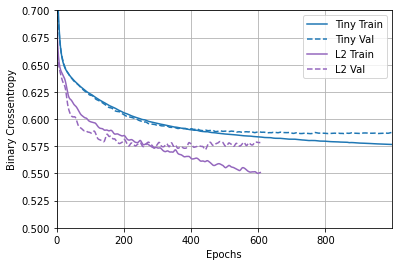

In [40]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [41]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

## Drop Out
- 드롭아웃을 층에 적용하면 훈련하는 동안 층의 출력 특성을 랜덤하게 0으로 만듦.
-  "드롭아웃 비율"은 0이 되는 특성의 비율이며 보통 0.2에서 0.5 사이를 사용함.

In [42]:
#두 개의 Dropout 층을 추가하여 과대적합이 얼마나 감소하는지 알아 볼 것.
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)              

(0.5, 0.7)

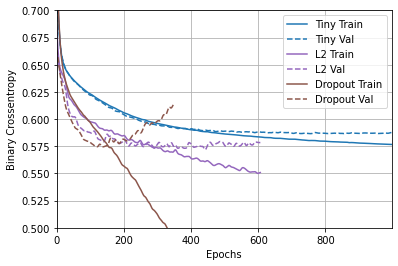

In [43]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [44]:
#Combined L2 + dropout

combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)              

(0.5, 0.7)

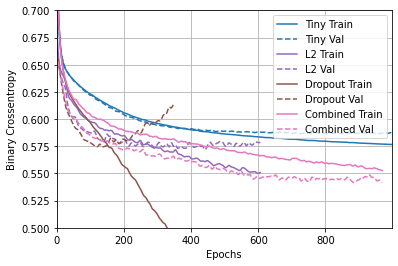

In [45]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

- 드롭아웃을 추가하니 기준 모델보다 확실히 향상된 것을 볼 수 있음.

- 과적합을 방지하기 위해 가장 널리 사용하는 방법은 
  - 더 많은 훈련 데이터를 모음
  - 네트워크의 용량을 줄임
  - 가중치 규제를 추가
  - 드롭아웃을 추가

In [46]:
%tensorboard --logdir {logdir}/regularizers

In [47]:
display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px")

In [48]:
tensorboard dev upload --logdir  {logdir}/regularizers

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2021-08-18 07:44:53.368451: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/tmp/tmplc_hx7tw/tensorboard_logs/regularizers

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Traceback (most recent call last):
  File "/opt/conda/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/opt/conda/lib/python3.7/site-pack